In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import svd
import matplotlib.pyplot as plt
import networkx as nx
import functions as fn

# Amazon Books

This dataset is publically available on Kaggle: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews

In [2]:
# ! unzip "/Users/fabiopimentel/clases/Seguendo año cuarto semestre/Optimization/proyecto/codigo/fabio/data/amazon_books.zip"

In [3]:
df_books_reviews = pd.read_csv(r"C:\Users\utente13\Desktop\data\Books_rating.csv")


In [4]:
df_books_reviews.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


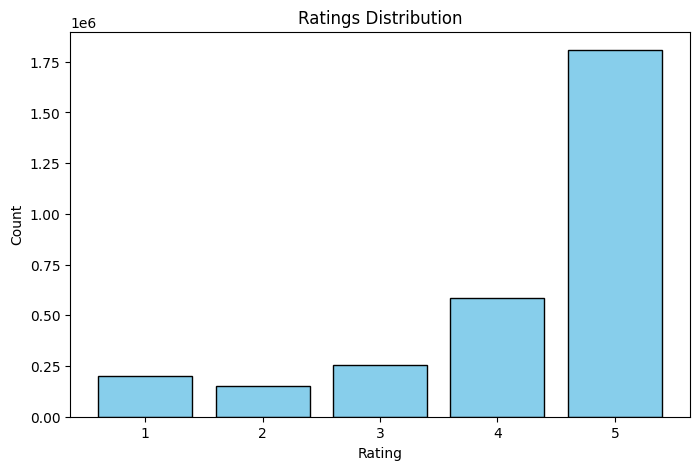

In [5]:
reviews_groups = df_books_reviews.groupby("review/score")["review/score"].count()

plt.figure(figsize=(8, 5))
plt.bar(reviews_groups.index, reviews_groups.values, color='skyblue', edgecolor='black')
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(reviews_groups.index)
plt.show()

# Inspecting the dataframe

In [6]:

n_users = df_books_reviews['User_id'].nunique() # Count how many unique users exist in the dataset
n_items = df_books_reviews['Id'].nunique() # Count how many unique items (products) exist in the dataset

n_obs = len(df_books_reviews) # Count how many (user, item, rating) rows exist
density = n_obs / (n_users * n_items) #   density = (# observed ratings) / (# possible user–item pairs)

print("users:", n_users, "items:", n_items, "observations:", n_obs, "density:", density)

# ---------------------------------------------------------------
# USER ACTIVITY DISTRIBUTION
# ---------------------------------------------------------------

# Compute how many ratings each user has:
#   df.groupby('user').size() returns a Series mapping user → count of ratings.
# Then we call `.describe(...)` to compute summary statistics such as:
#   min, max, mean, std, and selected percentiles.
user_counts = df_books_reviews.groupby('User_id').size().describe(percentiles=[.01,.05,.25,.5,.75,.95,.99])

# ---------------------------------------------------------------
# ITEM POPULARITY DISTRIBUTION
# ---------------------------------------------------------------

# Same logic as above, but grouping by items:
#   df.groupby('item').size() gives item → number of ratings
# Then `.describe(...)` summarizes it with percentiles.
item_counts = df_books_reviews.groupby('Id').size().describe(percentiles=[.01,.05,.25,.5,.75,.95,.99])


print("user counts:\n", user_counts)
print("item counts:\n", item_counts)

users: 1008972 items: 221998 observations: 3000000 density: 1.3393469053626162e-05
user counts:
 count    1.008972e+06
mean     2.416532e+00
std      1.213263e+01
min      1.000000e+00
1%       1.000000e+00
5%       1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
95%      7.000000e+00
99%      1.900000e+01
max      5.795000e+03
dtype: float64
item counts:
 count    221998.000000
mean         13.513635
std          76.174268
min           1.000000
1%            1.000000
5%            1.000000
25%           1.000000
50%           3.000000
75%           8.000000
95%          40.000000
99%         179.000000
max        6796.000000
dtype: float64


This matrix cannot be used for matrix completion in its current form.

That means:
- 99.9987% of the matrix entries are missing
- Average 2.4 ratings per user
- Median = 1 rating per user
- Average 13.5 ratings per item
- Median = 3 ratings per item
This is far below the threshold where matrix completion is possible.

Why is this a problem?
Matrix completion requires:
- Enough information per user to estimate their latent preferences
- Enough information per item to estimate its latent features
- A connected interaction graph (users ↔ items)
With 1 rating per user, the matrix is almost entirely disconnected.
Each user gives you almost no signal about their row of the matrix.

This is not a sparse “recommender system dataset”; it's essentially a very large set of isolated interactions.

# Preprocessing code before using the filtering pipeline

Why this step?

- The filtering pipeline assumes the dataframe has exactly:
    - user (user IDs)
    - item (item/product IDs)
    - rating (numeric rating signal)
- Extra columns will confuse the filtering steps, especially the bipartite graph construction (which expects only user/item identifiers).

In [7]:
# Reduce original dataframe
df_small = df_books_reviews.rename(columns={
    'User_id': 'user',
    'Id': 'item',
    'review/score': 'rating'
})[['user', 'item', 'rating']]

# Ensure types are consistent
df_small['user'] = df_small['user'].astype(str)
df_small['item'] = df_small['item'].astype(str)
df_small['rating'] = df_small['rating'].astype(float)


# Filtering Pipeline Code

In [8]:
########################################
# 1. Load data
########################################
# df must contain: 'user', 'item', 'rating'
# Example:
# df = pd.read_csv("amazon_books.csv")

########################################
# 2. Minimum-interactions filtering
########################################

def filter_min_interactions(df, min_user_ratings=5, min_item_ratings=5):
    """
    Iteratively filter users and items until all remaining users and items
    satisfy the minimum interaction thresholds.
    """
    prev_shape = (-1, -1)
    
    while True:
        # Filter users
        user_counts = df['user'].value_counts()
        good_users = user_counts[user_counts >= min_user_ratings].index
        df = df[df['user'].isin(good_users)]
        
        # Filter items
        item_counts = df['item'].value_counts()
        good_items = item_counts[item_counts >= min_item_ratings].index
        df = df[df['item'].isin(good_items)]

        # Stop if converged (no further data removed)
        if df.shape == prev_shape:
            break
        
        prev_shape = df.shape
    
    return df


########################################
# 3. Compute density of matrix
########################################

def compute_density(df):
    n_users = df['user'].nunique()
    n_items = df['item'].nunique()
    n_obs = len(df)
    density = n_obs / (n_users * n_items)
    return n_users, n_items, n_obs, density


########################################
# 4. Extract the largest connected component
########################################

def extract_largest_component(df):
    """
    Build bipartite graph (users ↔ items) and keep only entries inside 
    the largest connected component. This helps remove isolated pockets.
    """
    # Relabel with prefixes to avoid overlap
    df['user_node'] = df['user'].astype(str).apply(lambda x: f"u_{x}")
    df['item_node'] = df['item'].astype(str).apply(lambda x: f"i_{x}")

    G = nx.Graph()
    G.add_nodes_from(df['user_node'], bipartite=0)
    G.add_nodes_from(df['item_node'], bipartite=1)
    G.add_edges_from(zip(df['user_node'], df['item_node']))

    # Find largest connected component
    largest_cc = max(nx.connected_components(G), key=len)

    # Filter df to only nodes in the largest CC
    df = df[df['user_node'].isin(largest_cc) & df['item_node'].isin(largest_cc)]
    
    # Drop helper columns
    return df.drop(columns=['user_node', 'item_node'])


########################################
# 5. Full pipeline
########################################

def build_filtered_matrix(df, min_user_ratings=10, min_item_ratings=10):
    print("Original shape:", df.shape)

    # Step A: minimum-interaction filtering
    df_filt = filter_min_interactions(
        df, 
        min_user_ratings=min_user_ratings, 
        min_item_ratings=min_item_ratings
    )
    print("After min-count filtering:", df_filt.shape)
    
    # Step B: largest connected component
    df_cc = extract_largest_component(df_filt)
    print("After extracting largest connected component:", df_cc.shape)

    # Step C: recompute density
    n_users, n_items, n_obs, density = compute_density(df_cc)
    print("\n--- Final dataset stats ---")
    print("Users:", n_users)
    print("Items:", n_items)
    print("Observations:", n_obs)
    print("Density:", density)

    return df_cc


In [9]:
# Now run the filtering pipeline
df_filtered = build_filtered_matrix(df_small,
                                    min_user_ratings=20,
                                    min_item_ratings=20)

Original shape: (3000000, 3)
After min-count filtering: (651032, 3)
After extracting largest connected component: (650912, 3)

--- Final dataset stats ---
Users: 5892
Items: 7437
Observations: 650912
Density: 0.014854627250894387


The filtered dataset is now perfectly suitable for matrix completion and for running Frank–Wolfe or matrix completation experiments.

This means:

- The matrix contains enough signal
- Rows/columns are sufficiently connected
- Low-rank structure can be learned
- Frank–Wolfe is feasible
- Evaluation will be stable

The final size (5.9k × 7.4k) is big enough to be meaningful and small enough to run experiments fast.

In [10]:
df_filtered

,user,item,rating
392,nan,0671551345,5.0
393,nan,0671551345,3.0
395,nan,0671551345,5.0
396,nan,0671551345,5.0
398,nan,0671551345,5.0
...,...,...,...
2999689,nan,B000P91JYW,1.0
2999691,nan,B000P91JYW,1.0
2999692,nan,B000P91JYW,1.0
2999693,nan,B000P91JYW,1.0


In [11]:
# Taking the filtered data and transforming it into a user-rating matrix
user_rating_matrix = pd.pivot_table(df_filtered, values = "rating", index="user", columns="item").values

In [12]:
user_rating_matrix

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [3.9       , 4.61904762, 5.        , ..., 4.64705882, 3.07692308,
        5.        ]], shape=(5892, 7437))

In [13]:
# Replace NaN values with zero
user_rating_matrix[np.isnan(user_rating_matrix)] = 0

In [14]:
user_rating_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.9       , 4.61904762, 5.        , ..., 4.64705882, 3.07692308,
        5.        ]], shape=(5892, 7437))

In [15]:
print("Top Users count: {}\nTop books count: {} ".format(user_rating_matrix.shape[0],user_rating_matrix.shape[1]))

sparsity = (user_rating_matrix == 0).sum() / (user_rating_matrix.shape[0] * user_rating_matrix.shape[1])
print("Sparsity: {} %".format(round(sparsity * 100, 2)))

Top Users count: 5892
Top books count: 7437 
Sparsity: 99.37 %


99.37% sparsity is absolutely normal and acceptable for matrix completion.

Why sparsity ≠ bad for matrix completion

Frank-Wolfe–based matrix completion assumes:
- The matrix is low-rank or approximately low-rank
- You observe random entries (approximately)

Even with 99%+ sparsity, if:
- Each user has ≥20 ratings
- Each item has ≥20 ratings (your filtering ensures this)
- The graph is a single giant connected component (you ensured this too)

… then matrix completion is feasible.

# Dense Core Extraction for Amazon Books

In [16]:
import numpy as np

def extract_dense_core(R, movie_quantile=0.50, user_quantile=0.935):
    """
    Extract a dense core of the user-item matrix R using quantile filtering.
    
    R: numpy array (users x items), 0 = missing value.
    movie_quantile: quantile for item popularity
    user_quantile: quantile for user activity
    
    Returns:
        R_core: filtered dense-core matrix
        user_mask: boolean mask for selected users
        item_mask: boolean mask for selected items
    """

    # ----------------------------
    # 1. Count #ratings per user
    # ----------------------------
    user_counts = np.count_nonzero(R, axis=1)  # shape: (n_users,)

    # ----------------------------
    # 2. Count #ratings per item
    # ----------------------------
    item_counts = np.count_nonzero(R, axis=0)  # shape: (n_items,)

    # ----------------------------
    # 3. Compute quantile thresholds
    # ----------------------------
    user_threshold = np.quantile(user_counts, user_quantile)
    item_threshold = np.quantile(item_counts, movie_quantile)

    # ----------------------------
    # 4. Create masks
    # ----------------------------
    user_mask = user_counts >= user_threshold
    item_mask = item_counts >= item_threshold

    # ----------------------------
    # 5. Extract dense core
    # ----------------------------
    R_core = R[user_mask][:, item_mask]

    return R_core, user_mask, item_mask


In [17]:
R_core, user_mask, item_mask = extract_dense_core(
    R=user_rating_matrix, 
    movie_quantile=0.50,
    user_quantile=0.935
)

print("Original shape:", user_rating_matrix.shape)
print("Dense core shape:", R_core.shape)

sparsity = (R_core == 0).sum() / (R_core.size)
print("Sparsity: {:.2f}%".format(sparsity * 100))


Original shape: (5892, 7437)
Dense core shape: (389, 3866)
Sparsity: 95.53%


Why is the dense core still very sparse (95.53%)?

Because Amazon is extremely sparse by nature.

Even after quantile filtering:
- You kept only top 6.6% most active users
- And top 50% most popular items
- But unlike MovieLens, in Amazon:
- Power users don’t rate thousands of items
- Popular items aren't rated by tens of thousands of users
- Even the “most active” users only rate ~20–50 items
- Even the “most popular” books may only have ~40–200 reviews

Result:

👉 The dense core is still sparse.

This is not a problem — this is typical for Amazon books.

The dense cores of Amazon data rarely go below 90% sparsity.

MovieLens dense cores are 25–35% sparsity because:
- users watch many movies
- movies get many ratings
- their distributions are extremely power-law heavy

Amazon Books does NOT behave that way.

In [18]:
import sys
import os

# Add the directory containing functions.py to the path if necessary
# (Assuming functions.py is in the same folder as the notebook)
sys.path.append('.') 

import functions as fn
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [19]:
def train_test_split(R, test_ratio=0.2, seed=42):
    """
    Masks a percentage of the non-zero entries in R to create a test set.
    """
    np.random.seed(seed)
    
    # Get coordinates of observed ratings
    rows, cols = R.nonzero()
    n_observed = len(rows)
    
    # Select indices for testing
    test_size = int(n_observed * test_ratio)
    perm = np.random.permutation(n_observed)
    test_indices = perm[:test_size]
    train_indices = perm[test_size:]
    
    # Create Train Matrix (R with test entries removed/set to 0)
    R_train = R.copy()
    R_train[rows[test_indices], cols[test_indices]] = 0
    
    # Create Test Matrix (Only the entries we masked)
    R_test = np.zeros_like(R)
    R_test[rows[test_indices], cols[test_indices]] = R[rows[test_indices], cols[test_indices]]
    
    return R_train, R_test

# Execute the split on your dense core
R_train, R_test = train_test_split(R_core, test_ratio=0.2)
print(f"Train stats: {np.count_nonzero(R_train)} ratings")
print(f"Test stats: {np.count_nonzero(R_test)} ratings")

Train stats: 53721 ratings
Test stats: 13430 ratings


In [22]:
import matplotlib.pyplot as plt
import importlib
import functions as fn

# 1. Ricarica le funzioni (fondamentale se hai appena modificato functions.py)
importlib.reload(fn)

# 2. Imposta i parametri
# Delta dipende dai dati. Per rating 1-5 e matrici di queste dimensioni, 
# un valore tra 1000 e 5000 è spesso un buon punto di partenza.
DELTA = 12000
MAX_ITER = 3000

print(f"--- TEST FW STANDARD (Delta={DELTA}) ---")

# 3. Esegui l'algoritmo (usiamo Armijo che è più veloce)
# Se vuoi provare la grid search, cambia ls_method='grid'
P_hat, history, gaps = fn.FW_standard(
    R_train, 
    delta=DELTA, 
    max_iter=MAX_ITER, 
    tol=1e-3, 
    init_type='zeros',    # Puoi provare anche 'random'
    ls_method='armijo'    # La tua scelta efficiente
)

# 4. Valutazione sul Test Set
# Usiamo la tua funzione di loss per calcolare l'RMSE sui dati nascosti
test_rmse = fn.function_loss(R_test, P_hat)

print(f"\nRISULTATI FINALI:")
print(f"Final Training RMSE: {history[-1]:.4f}")
print(f"Final Test RMSE:     {test_rmse:.4f}")
print(f"Final Duality Gap:   {gaps[-1]:.4f}")

# 5. Grafici di Convergenza
plt.figure(figsize=(12, 5))

# Grafico Loss (RMSE)
plt.subplot(1, 2, 1)
plt.plot(history, marker='o', label='Train RMSE')
plt.axhline(y=test_rmse, color='r', linestyle='--', label=f'Test RMSE ({test_rmse:.3f})')
plt.xlabel('Iterazioni')
plt.ylabel('RMSE')
plt.title('Convergenza della Loss')
plt.legend()
plt.grid(True)

# Grafico Duality Gap (deve andare a zero)
plt.subplot(1, 2, 2)
plt.plot(gaps, marker='o', color='orange', label='Duality Gap')
plt.xlabel('Iterazioni')
plt.ylabel('Gap')
plt.yscale('log') # Scala logaritmica perché il gap scende molto veloce
plt.title('Convergenza del Duality Gap')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

--- TEST FW STANDARD (Delta=12000) ---


KeyboardInterrupt: 